# 1 - Import requirements

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm

# 2 - Prepare data

In [3]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

In [11]:
def load_shape(shape_path):
    with open(shape_path, 'r') as f:
        shape = f.readlines()
        n_samples = int(shape[0])
        seq_len = int(shape[1])
        n_features = int(shape[2])
    return n_samples, seq_len, n_features

class TradingDataset(Dataset):
    def __init__(self, save_path, n_samples, sequence_length, n_features):
        self.save_path = save_path
        self.n_samples = n_samples
        self.sequences = np.memmap(f'{save_path}/sequences.dat', dtype=np.float32, mode='r', 
                                 shape=(n_samples, sequence_length, n_features))
        self.labels = np.memmap(f'{save_path}/labels.dat', dtype=np.int64, mode='r', 
                              shape=(n_samples,))
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].copy()  # Tạo bản sao writable
        lbl = self.labels[idx].copy()
        return torch.from_numpy(seq).float(), torch.from_numpy(np.array([lbl])).long()[0]

def prepare_transformer_input(train_shape_path, val_shape_path, test_shape_path, data_path, batch_size=32):    
    n_train_samples, sequence_length, n_features = load_shape(train_shape_path)
    n_val_samples, _, _ = load_shape(val_shape_path)
    n_test_samples, _, _ = load_shape(test_shape_path)
    
    train_path = f'{data_path}/train'
    val_path = f'{data_path}/val'
    test_path = f'{data_path}/test'
    
    # Tạo datasets
    train_dataset = TradingDataset(train_path, n_train_samples, sequence_length, n_features)
    val_dataset = TradingDataset(val_path, n_val_samples, sequence_length, n_features)
    test_dataset = TradingDataset(test_path, n_test_samples, sequence_length, n_features)
    
    # Tạo dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [12]:
train_shape_path = '/kaggle/input/processed-xauusd/train/shape.txt'
val_shape_path = '/kaggle/input/processed-xauusd/val/shape.txt'
test_shape_path = '/kaggle/input/processed-xauusd/test/shape.txt'


train_loader, val_loader, test_loader = prepare_transformer_input(
    train_shape_path, val_shape_path, test_shape_path,
    data_path='/kaggle/input/processed-xauusd',
    batch_size=64
)

In [13]:
# Kiểm tra
sample_batch = next(iter(train_loader))
print("Batch input shape:", sample_batch[0].shape)
print("Batch labels shape:", sample_batch[1].shape)
print("\nExample input shape for Transformer:", sample_batch[0][0].shape)
print(sample_batch[0][0])
print("Number of batches:", len(train_loader))

Batch input shape: torch.Size([64, 128, 27])
Batch labels shape: torch.Size([64])

Example input shape for Transformer: torch.Size([128, 27])
tensor([[-0.7127, -0.7133, -0.7126,  ..., -0.6439,  0.8317,  0.8950],
        [-0.7129, -0.7134, -0.7127,  ..., -0.6439,  0.8317,  0.8950],
        [-0.7132, -0.7137, -0.7134,  ..., -0.6439,  0.8317,  0.8950],
        ...,
        [-0.7067, -0.7072, -0.7065,  ..., -1.1719,  0.8317,  0.8950],
        [-0.7070, -0.7071, -0.7064,  ..., -1.1719,  0.8317,  0.8950],
        [-0.7065, -0.7067, -0.7068,  ..., -1.1719,  0.8317,  0.8950]])
Number of batches: 1642


# 3 - Build model

In [30]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class TradingTransformer(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes=3, 
                 d_model=512,
                 nhead=8,
                 num_layers=6,
                 dropout=0.1):
        super().__init__()
        
        # 1. Feature Projection
        self.input_proj = nn.Linear(num_features, d_model)
        
        # 2. Positional Encoding (Learnable)
        self.pos_encoder = LearnablePositionalEncoding(d_model, dropout)
        
        # 3. Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True 
        )
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
        # 4. Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )
        
    #     # 5. Initialize weights
    #     self.init_weights()

    # def init_weights(self):
    #     for p in self.parameters():
    #         if p.dim() > 1:
    #             nn.init.xavier_uniform_(p)

    def forward(self, src):
        """
        Args:
            src: Tensor shape [batch_size, seq_len, num_features]
        Returns:
            output: Tensor shape [batch_size, num_classes]
        """
        # Project input features
        x = self.input_proj(src)  # [B, S, D]
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer processing
        memory = self.transformer_encoder(x)  # [B, S, D]
        
        # Get last time step output
        last_output = memory[:, -1, :]  # [B, D]
        
        # Classification
        return self.classifier(last_output)


class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.position_emb = nn.Parameter(torch.zeros(max_len, d_model))
        nn.init.normal_(self.position_emb, mean=0, std=0.02)

    def forward(self, x):
        """
        Args:
            x: Tensor shape [B, S, D]
        """
        positions = self.position_emb[:x.size(1), :]  # [S, D]
        x = x + positions.unsqueeze(0)  # [B, S, D]
        return self.dropout(x)

In [31]:
N_FEATURES = 27
model = TradingTransformer(N_FEATURES)

model(sample_batch[0]).shape, sample_batch[1].shape

(torch.Size([64, 3]), torch.Size([64]))

In [32]:
from torchinfo import summary
print(summary(model, (64, 128, 27)))

Layer (type:depth-idx)                        Output Shape              Param #
TradingTransformer                            [64, 3]                   --
├─Linear: 1-1                                 [64, 128, 512]            14,336
├─LearnablePositionalEncoding: 1-2            [64, 128, 512]            2,560,000
│    └─Dropout: 2-1                           [64, 128, 512]            --
├─TransformerEncoder: 1-3                     [64, 128, 512]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-2      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-3      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-4      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-5      [64, 128, 512]            3,152,384
│    │    └─TransformerEncoderLayer: 3-6      [64

# 4 - Train and Evaluate model

In [33]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        """
        patience: Số epoch chờ mà không cải thiện trước khi dừng
        min_delta: Độ cải thiện tối thiểu để coi là tốt hơn
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def eval_model(model, val_loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, unit='batch', desc='\tEvaluating: '):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, -1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.to(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels in tqdm(train_loader, unit='batch', desc=f'\tTraining: '):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, -1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    scheduler.step()
    
    return epoch_loss, epoch_acc

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
NUM_EPOCHS = 20
PATIENCE = 3
MIN_DELTA = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
    
train_losses = []
train_accs = []
val_losses = []
val_accs = []

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

for epoch in range(NUM_EPOCHS):
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, DEVICE)
    val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)
    
    print(f'\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'\tVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Kiểm tra Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
    print('===================================================')

Epoch [1/20]


	Evaluating: 100%|██████████| 549/549 [00:31<00:00, 17.45batch/s]


	Train Loss: 0.9963, Train Accuracy: 52.46%
	Val Loss: 1.0517, Val Accuracy: 47.97%
Epoch [2/20]


	Training:  10%|█         | 165/1642 [00:29<04:24,  5.59batch/s]

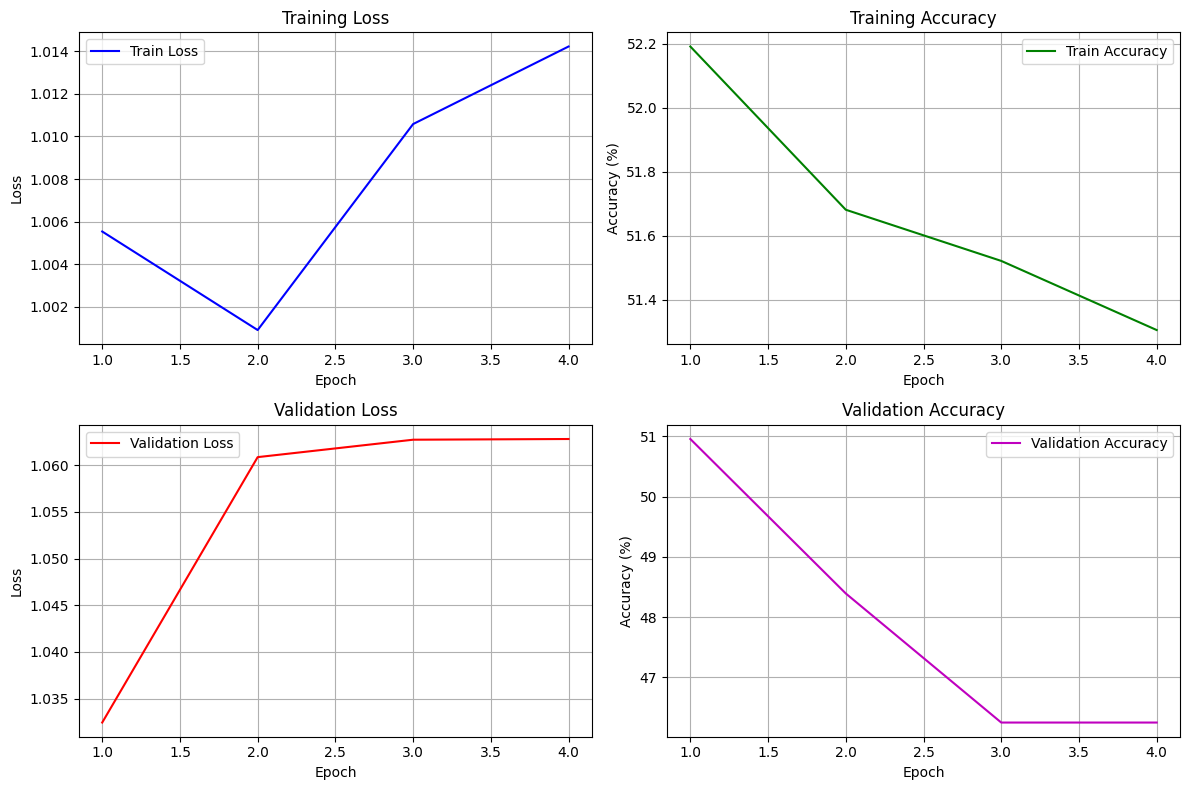

In [23]:
import matplotlib.pyplot as plt
def plot_training_results(train_losses, train_accs, val_losses, val_accs):
    """
    Vẽ biểu đồ kết quả huấn luyện: loss và accuracy cho train và validation.
    
    Parameters:
    - train_losses: List các giá trị loss của train qua các epoch
    - train_accs: List các giá trị accuracy của train qua các epoch
    - val_losses: List các giá trị loss của validation qua các epoch
    - val_accs: List các giá trị accuracy của validation qua các epoch
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Tạo figure với 2x2 subplot
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Train Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Train Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accs, 'g-', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Validation Loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 4: Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_accs, 'm-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Điều chỉnh layout và hiển thị
    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, train_accs, val_losses, val_accs)

In [24]:
torch.save(model.state_dict(), 'model.pth')

In [25]:
def test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)  # [B, seq_len, n_features]
            batch_y = batch_y.to(device)

            outputs = model(batch_x)  # Expecting [B, num_classes]
            preds = torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    target_names = ['BUY', 'SELL', 'HOLD']
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4, zero_division=0))

In [26]:
test_model(model, train_loader, DEVICE)

Classification Report:
              precision    recall  f1-score   support

         BUY     0.0000    0.0000    0.0000     32225
        SELL     0.0000    0.0000    0.0000     21478
        HOLD     0.4887    1.0000    0.6565     51325

    accuracy                         0.4887    105028
   macro avg     0.1629    0.3333    0.2188    105028
weighted avg     0.2388    0.4887    0.3208    105028



In [27]:
test_model(model, val_loader, DEVICE)

Classification Report:
              precision    recall  f1-score   support

         BUY     0.0000    0.0000    0.0000     11373
        SELL     0.0000    0.0000    0.0000      7485
        HOLD     0.4625    1.0000    0.6325     16225

    accuracy                         0.4625     35083
   macro avg     0.1542    0.3333    0.2108     35083
weighted avg     0.2139    0.4625    0.2925     35083



In [28]:
test_model(model, test_loader, DEVICE)

Classification Report:
              precision    recall  f1-score   support

         BUY     0.0000    0.0000    0.0000     36621
        SELL     0.0000    0.0000    0.0000     24480
        HOLD     0.4579    1.0000    0.6282     51620

    accuracy                         0.4579    112721
   macro avg     0.1526    0.3333    0.2094    112721
weighted avg     0.2097    0.4579    0.2877    112721



In [29]:
def get_prediction(model, inputs, device):
    # inputs = [B, S, N]
    model.to(device)
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=-1)
    return preds.cpu().numpy()

SyntaxError: incomplete input (<ipython-input-29-a814c95eceb0>, line 4)